## The goal of Decision Tree is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. 


In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

In [2]:
outliers_df = pd.read_csv('outliers.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7617 entries, 0 to 7616
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7617 non-null   float64
 1   bath            7617 non-null   float64
 2   acre_lot        7617 non-null   float64
 3   zip_code        7617 non-null   float64
 4   house_size      7617 non-null   float64
 5   prev_sold_date  7617 non-null   object 
 6   price           7617 non-null   float64
dtypes: float64(6), object(1)
memory usage: 416.7+ KB


In [4]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7617 entries, 0 to 7616
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7617 non-null   float64
 1   bath            7617 non-null   float64
 2   acre_lot        7617 non-null   float64
 3   zip_code        7617 non-null   float64
 4   house_size      7617 non-null   float64
 5   price           7617 non-null   float64
 6   prev_sold_year  7617 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 416.7 KB


In [5]:
outliers_df["zip_code_str"] = np.where(outliers_df.zip_code.apply(int) < 10000,'0'+ outliers_df.zip_code.apply(int).apply(str),outliers_df.zip_code.apply(int).apply(str))
outliers_df.head()

,bed,bath,acre_lot,zip_code,house_size,price,prev_sold_year,zip_code_str
0,3.0,2.0,0.14,7001.0,1542.0,305100.0,2022,07001
1,3.0,2.0,0.11,7001.0,1500.0,479000.0,2016,07001
2,3.0,2.0,0.17,7001.0,7501.0,340000.0,2021,07001
3,5.0,2.0,0.18,7001.0,1387.0,484000.0,2020,07001
4,3.0,2.0,0.17,7001.0,1500.0,425000.0,2019,07001


In [6]:
zip_lon_lat = pd.read_csv('nj_zip-lon-lat.csv')
zip_lon_lat["zip_code_str"] = np.where(zip_lon_lat.zip_code.apply(int) < 10000,'0'+ zip_lon_lat.zip_code.apply(int).apply(str),zip_lon_lat.zip_code.apply(int).apply(str))
zip_lon_lat.head()

,zip_code,latitude,longitude,zip_code_str
0,7001,40.582316,-74.271506,07001
1,7002,40.662338,-74.110275,07002
2,7003,40.809128,-74.187155,07003
3,7004,40.882508,-74.304593,07004
4,7005,40.932771,-74.417304,07005


In [7]:
merged_df = pd.merge(outliers_df, zip_lon_lat, how='inner', on="zip_code_str")
merged_df.tail()

,bed,bath,acre_lot,zip_code_x,house_size,price,prev_sold_year,zip_code_str,zip_code_y,latitude,longitude
7609,5.0,4.0,0.91,8848.0,1500.0,485000.0,2017,08848,8848,40.594266,-75.096659
7610,4.0,3.0,2.17,8825.0,1500.0,510000.0,2016,08825,8825,40.514169,-75.027112
7611,3.0,2.0,0.12,7012.0,1500.0,499000.0,2021,07012,7012,40.848398,-74.160266
7612,3.0,3.0,0.13,7012.0,1500.0,530000.0,2022,07012,7012,40.848398,-74.160266
7613,4.0,3.0,0.11,7640.0,1500.0,720000.0,2016,07640,7640,40.991681,-73.980202


In [8]:
features = ["latitude","longitude","bed","bath","house_size","prev_sold_year"]
num_features_to_select = len(features)-1
random_state_value = 42

In [9]:
X = merged_df[features]
y = merged_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

In [10]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

In [11]:
def print_more_stuff(title, y_param, predict_param, gscv):
    results_dict["model"].append(title)
    
    evs = "{:.9f}".format(explained_variance_score(y_param,predict_param))
    mae = "{:,.6f}".format(mean_absolute_error(y_param,predict_param))
    mse = "{:,.6f}".format(mean_squared_error(y_param,predict_param))
    r2 = "{:,.6f}".format(r2_score(y_param,predict_param))
    
    #find_best_params = gscv.cv_results_["params"].index(gscv.best_params_)
    #mean_fit_time = gscv.cv_results_["mean_fit_time"][find_best_params]
    mean_fit_time = gscv.cv_results_["mean_fit_time"][gscv.best_index_]
    
    results_dict["explained variance score"].append(evs)
    results_dict["mae score"].append(mae)
    results_dict["mse score"].append(mse)
    results_dict["r2 score"].append(r2)
    results_dict["mean fit time"].append(mean_fit_time)
    
    print(title + " EVS = " + evs)
    print(title + " MSE = " + mse)
    print(title + " MAE = " + mae)
    print(title + " R2 = " + r2)
    print(title + " Fit Time = " + str(mean_fit_time))

### GridSearchCV exhaustively generates candidates from a grid of parameter values specified.

In [12]:
params = {'max_depth': range(5,15,1),
         'random_state':[42]}

grid = GridSearchCV(DecisionTreeRegressor(), param_grid=params).fit(X_train, y_train)
grid_train_acc = grid.score(X_train, y_train)
grid_test_acc = grid.score(X_test, y_test)
best_params = grid.best_params_
best_params

{'max_depth': 8, 'random_state': 42}

#### The best params attribute will be used to fit  model with the training data and make a prediction with the test data.

In [13]:
dtree = DecisionTreeRegressor(**best_params)
dtree_gscv = GridSearchCV(dtree, param_grid={})
dtree_model = dtree_gscv.fit(X_train,y_train)
dtree_bp_predict = dtree_model.predict(X_test)

print_more_stuff("Decision Tree Best Params", y_test, dtree_bp_predict, dtree_gscv)

Decision Tree Best Params EVS = 0.525465856
Decision Tree Best Params MSE = 76,497,959,521.268478
Decision Tree Best Params MAE = 161,667.633996
Decision Tree Best Params R2 = 0.524659
Decision Tree Best Params Fit Time = 0.011514043807983399


#### cost_complexity_pruning_path

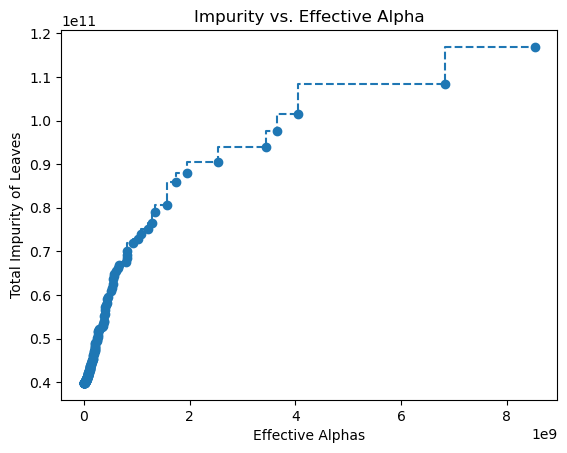

In [14]:
path = dtree.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas = path.ccp_alphas
impurities = path.impurities

plt.step(ccp_alphas[:-1], impurities[:-1], '--o')
plt.title('Impurity vs. Effective Alpha')
plt.xlabel('Effective Alphas')
plt.ylabel('Total Impurity of Leaves');

### Recursive feature elimination uses an external estimator that assigns weights to features with the goal of selecting features by recursively considering smaller and smaller sets of features.

In [15]:
dtree_rfe = RFE(DecisionTreeRegressor(), n_features_to_select=num_features_to_select)
dtree_rfe.fit(X, y)
dtree_rfe_selected_features = dtree_rfe.get_support()
print('The selected features are:', list(X.columns[dtree_rfe_selected_features]))

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size']


In [16]:
X_rfe = merged_df[list(X.columns[dtree_rfe_selected_features])]
y_rfe = merged_df["price"]
X_rfe_train, X_rfe_test, y_rfe_train, y_rfe_test = train_test_split(X_rfe, y_rfe, test_size=0.3, random_state=random_state_value)

In [17]:
dtree_rfe_gscv = GridSearchCV(DecisionTreeRegressor(),param_grid={})
dtree_rfe_model = dtree_rfe_gscv.fit(X_rfe_train,y_rfe_train)
dtree_rfe_predict = dtree_rfe_model.predict(X_rfe_test)

print_more_stuff("Recursive Feature Elimination", y_rfe_test, dtree_rfe_predict, dtree_rfe_gscv)

Recursive Feature Elimination EVS = 0.436786671
Recursive Feature Elimination MSE = 90,755,190,129.637604
Recursive Feature Elimination MAE = 168,608.561912
Recursive Feature Elimination R2 = 0.436068
Recursive Feature Elimination Fit Time = 0.02264103889465332


###  Sequential Feature Selector (forward selection) adds features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator. 

In [18]:
dtree_sfs = SequentialFeatureSelector(DecisionTreeRegressor(), n_features_to_select=num_features_to_select)
dtree_sfs.fit(X, y)
dtree_sfs_selected_features = dtree_sfs.get_support()
print('The selected features are:', list(X.columns[dtree_sfs_selected_features]))

The selected features are: ['longitude', 'bed', 'bath', 'house_size', 'prev_sold_year']


In [19]:
X_sfs = merged_df[list(X.columns[dtree_sfs_selected_features])]
y_sfs = merged_df["price"]
X_sfs_train, X_sfs_test, y_sfs_train, y_sfs_test = train_test_split(X_sfs, y_sfs, test_size=0.3, random_state=random_state_value)

In [20]:
dtree_sfs_gscv = GridSearchCV(DecisionTreeRegressor(),param_grid={})
dtree_sfs_model = dtree_sfs_gscv.fit(X_sfs_train,y_sfs_train)
dtree_sfs_predict = dtree_sfs_model.predict(X_sfs_test)
dtree_sfs_mse = mean_squared_error(y_sfs_test,dtree_sfs_predict)

print_more_stuff("Sequential Feature Selector", y_sfs_test, dtree_sfs_predict, dtree_sfs_gscv)

Sequential Feature Selector EVS = 0.298092052
Sequential Feature Selector MSE = 113,096,412,321.979813
Sequential Feature Selector MAE = 196,732.171907
Sequential Feature Selector R2 = 0.297245
Sequential Feature Selector Fit Time = 0.024436235427856445


#### Graphing the results works best when the data is provided in a DataFrame.

In [21]:
dtree_bp_predict_df = pd.DataFrame(dtree_bp_predict).reset_index()
dtree_bp_predict_df.rename(columns={0: "prediction"},inplace=True)

dtree_sfs_predict_df = pd.DataFrame(dtree_sfs_predict).reset_index()
dtree_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

dtree_rfe_predict_df = pd.DataFrame(dtree_rfe_predict).reset_index()
dtree_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

#### The predictions provided by the best parameters have the appearance of banding.  I will conduct more testing to determine if this is acceptable or if this is a case of underfitting or overfitting.

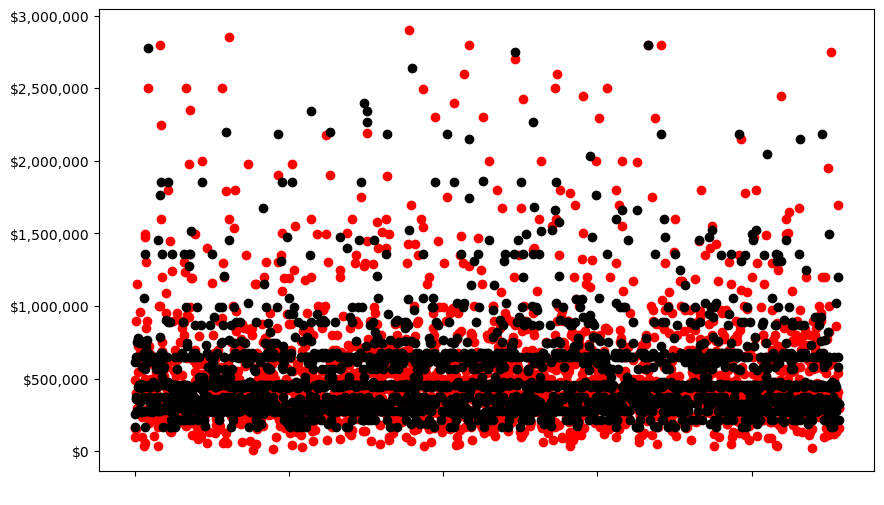

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(dtree_bp_predict_df.index,dtree_bp_predict_df["prediction"], color="black")
plt.show()

#### Scatter Plot graph of the results of Recursive Feature Elimination, Sequential Feature Selection, and Test Data.

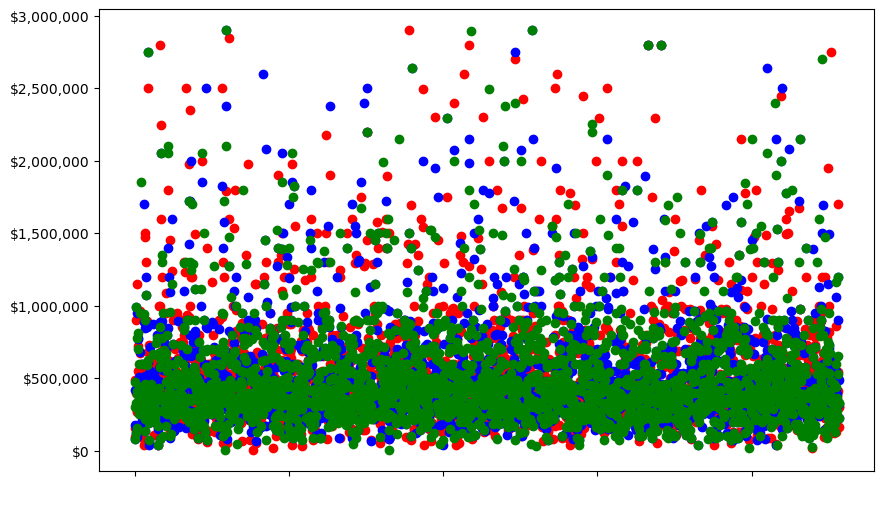

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(dtree_rfe_predict_df.index,dtree_rfe_predict_df["prediction"], color="blue")
plt.scatter(dtree_sfs_predict_df.index,dtree_sfs_predict_df["prediction"], color="green")
plt.show()

#### Sort the DataFrames by the Prediction and Price features.

In [24]:
dtree_bp_predict_df.sort_values(by='prediction', inplace=True)
dtree_bp_predict_df.reset_index(inplace=True)

dtree_sfs_predict_df.sort_values(by='prediction', inplace=True)
dtree_sfs_predict_df.reset_index(inplace=True)

dtree_rfe_predict_df.sort_values(by='prediction', inplace=True)
dtree_rfe_predict_df.reset_index(inplace=True)

y_test_df.sort_values(by='price', inplace=True)
y_test_df.reset_index(inplace=True)

#### Line graph of the results of Recursive Feature Elimination, Sequential Feature Selection, and Test Data.

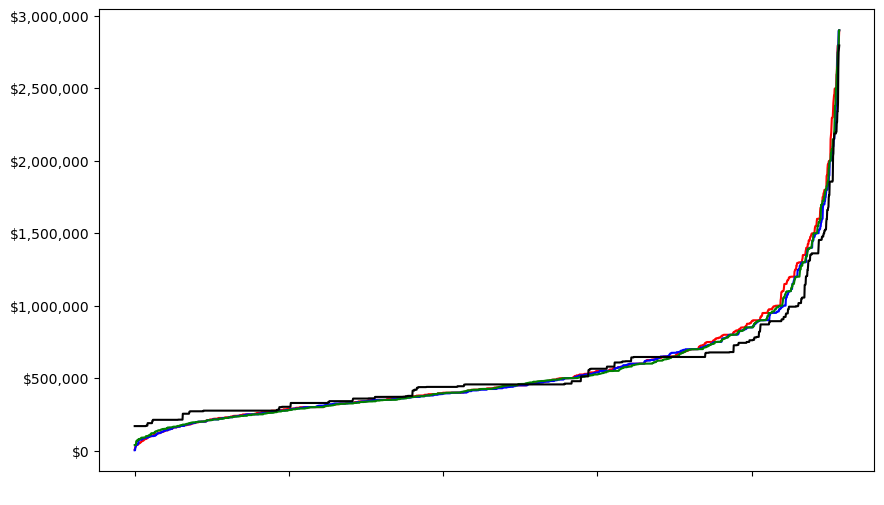

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.plot(y_test_df.index,y_test_df["price"], color="red")
plt.plot(dtree_sfs_predict_df.index,dtree_sfs_predict_df["prediction"], color="blue")
plt.plot(dtree_rfe_predict_df.index,dtree_rfe_predict_df["prediction"], color="green")
plt.plot(dtree_bp_predict_df.index,dtree_bp_predict_df["prediction"], color="black")
plt.show()

#### Output the results so they can be copied into another Notebook comparing the results of all the models.

In [26]:
results_dict

{'model': ['Decision Tree Best Params',
  'Recursive Feature Elimination',
  'Sequential Feature Selector'],
 'explained variance score': ['0.525465856', '0.436786671', '0.298092052'],
 'mae score': ['161,667.633996', '168,608.561912', '196,732.171907'],
 'mse score': ['76,497,959,521.268478',
  '90,755,190,129.637604',
  '113,096,412,321.979813'],
 'r2 score': ['0.524659', '0.436068', '0.297245'],
 'mean fit time': [0.011514043807983399,
  0.02264103889465332,
  0.024436235427856445]}

In [27]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Decision Tree Best Params,0.525465856,"161,667.633996","76,497,959,521.268478",0.524659,0.011514
Recursive Feature Elimination,0.436786671,"168,608.561912","90,755,190,129.637604",0.436068,0.022641
Sequential Feature Selector,0.298092052,"196,732.171907","113,096,412,321.979813",0.297245,0.024436
